### Importing the required libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'GradientBoosting']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          GradientBoostingClassifier(random_state=0)]

## Calculate the accuracy of the model
def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

## Plot the accuracy of the model VS Generation
def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [4]:

##Generate the initial population
def generate_random_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

##Calculate the fitness of the population
def fitness(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 


In [5]:
## Select the best chromosomes
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

## Crossover
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

## Mutation
def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

##Geneartion
def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=generate_random_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

### Breast Cancer Dataset


In [6]:
data_bc = pd.read_csv("data.csv")
label_bc = data_bc["diagnosis"]
label_bc = np.where(label_bc == 'M',1,0)
data_bc.drop(["id","diagnosis","Unnamed: 32"],axis = 1,inplace = True)

print("Breast Cancer dataset:\n",data_bc.shape[0],"Records\n",data_bc.shape[1],"Features")

Breast Cancer dataset:
 569 Records
 30 Features


### 2. Accuracies Of All Models

In [7]:
score1 = acc_score(data_bc,label_bc)
score1

,Classifier,Accuracy
0,RandomForest,0.972028
1,LinearSVM,0.958042
2,Logistic,0.958042
3,GradientBoosting,0.958042
4,RadialSVM,0.951049
5,AdaBoost,0.951049
6,DecisionTree,0.930070


In [8]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
X_train,X_test, Y_train, Y_test = split(data_bc,label_bc)
chromo_df_bc,score_bc=generations(data_bc,label_bc,size=80,n_feat=data_bc.shape[1],n_parents=64,mutation_rate=0.20,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [0.986013986013986]
Best score in generation 2 : [0.993006993006993]
Best score in generation 3 : [0.993006993006993]
Best score in generation 4 : [0.993006993006993]
Best score in generation 5 : [0.993006993006993]


In [9]:
def disp(c,df,g):
    feature=df.columns
    t=0
    l=[]
    for i in c:
        if i==False:
               pass
        else:
            l.append(feature[t])
        t+=1
    print("The features selected for generation", g ,"are" )
    print(l)
    print()

In [10]:
m=len(chromo_df_bc)
for k in range(0,m):
    disp(chromo_df_bc[k],data_bc,k+1)

The features selected for generation 1 are
['texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'perimeter_se', 'area_se', 'smoothness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']

The features selected for generation 2 are
['radius_mean', 'smoothness_mean', 'compactness_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concave points_se', 'fractal_dimension_se', 'radius_worst', 'smoothness_worst', 'fractal_dimension_worst']

The features selected for generation 3 are
['perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'fractal_dimension_se', 'smoothness

#### We can see an improvement of 1-2%

### 3. Visualization

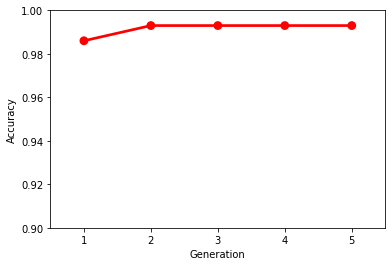

In [11]:
plot(score_bc,0.9,1.0,c = "red")

_____
# Parkinson's disease
_____

### 1. Looking at dataset

In [12]:
data_pd = pd.read_csv("Parkinsson disease.csv")
label_pd = data_pd["status"]
data_pd.drop(["status","name"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

Parkinson's disease dataset:
 195 Records
 22 Features


In [13]:
display(data_pd.head())
print("All the features in this dataset have continuous values")

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


All the features in this dataset have continuous values


### 2. Checking Accuracy

In [14]:
score3 = acc_score(data_pd,label_pd)
score3

,Classifier,Accuracy
0,RandomForest,0.918367
1,Logistic,0.897959
2,GradientBoosting,0.897959
3,LinearSVM,0.877551
4,DecisionTree,0.877551
5,AdaBoost,0.857143
6,RadialSVM,0.836735


In [15]:
logmodel = DecisionTreeClassifier(random_state=0)
X_train,X_test, Y_train, Y_test = split(data_pd,label_pd)
chromo_df_pd,score_pd=generations(data_pd,label_pd,size=80,n_feat=data_pd.shape[1],n_parents=64,mutation_rate=0.20,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)




Best score in generation 1 : [0.9387755102040817]
Best score in generation 2 : [0.9591836734693877]
Best score in generation 3 : [0.9591836734693877]
Best score in generation 4 : [0.9795918367346939]
Best score in generation 5 : [0.9795918367346939]


In [16]:



m=len(chromo_df_pd)

for k in range(0,m):
    disp(chromo_df_pd[k],data_pd,k+1)

The features selected for generation 1 are
['MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'MDVP:APQ', 'HNR', 'RPDE', 'DFA', 'spread1', 'D2', 'PPE']

The features selected for generation 2 are
['MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:DDA', 'HNR', 'RPDE', 'spread2', 'D2', 'PPE']

The features selected for generation 3 are
['MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

The features selected for generation 4 are
['MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(Abs)', 'MDVP:PPQ', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2']

The features selected for generation 5 are
['MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(Abs)', 'Jitter:DDP', 'MDVP:Shimmer', 'MDV

#### We can see an improvement of 5-7%

### 3. Visualization

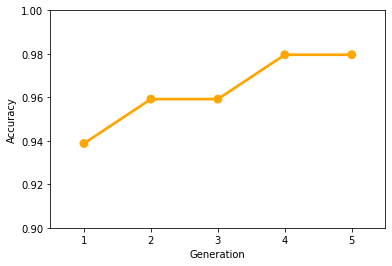

In [17]:
plot(score_pd,0.9,1.0,c = "orange")